### Household Data

In [1]:
import pandas as pd
import tarfile
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read data from Github and return as DataFrame using pandas library

def housing_data():
    tarball_path = Path("datasets/housing.tgz") 
    if not tarball_path.is_file():                                  # check the above file (housing.tgz) in current directory
        Path("datasets").mkdir(parents=True, exist_ok=True)         # create datasets directory in current directory
        url = "https://github.com/ageron/data/raw/main/housing.tgz" 
        urllib.request.urlretrieve(url, tarball_path)               # pull data from remote directory and save in datsets directory
        with tarfile.open(tarball_path, 'r:gz') as housing_tarball:
            housing_tarball.extractall(path = "datasets", filter="data")   # extract data from .tgz file 
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [3]:
# Save figures in local directory

IMAGE_PATH = Path() / "images"
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

def save_image(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGE_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
housing = housing_data()

In [5]:
housing.head() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing['ocean_proximity'].value_counts() # checking value counts for ocean_proxity attribute because it's contain duplicate value and datatype is object

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe() # display summary for all numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


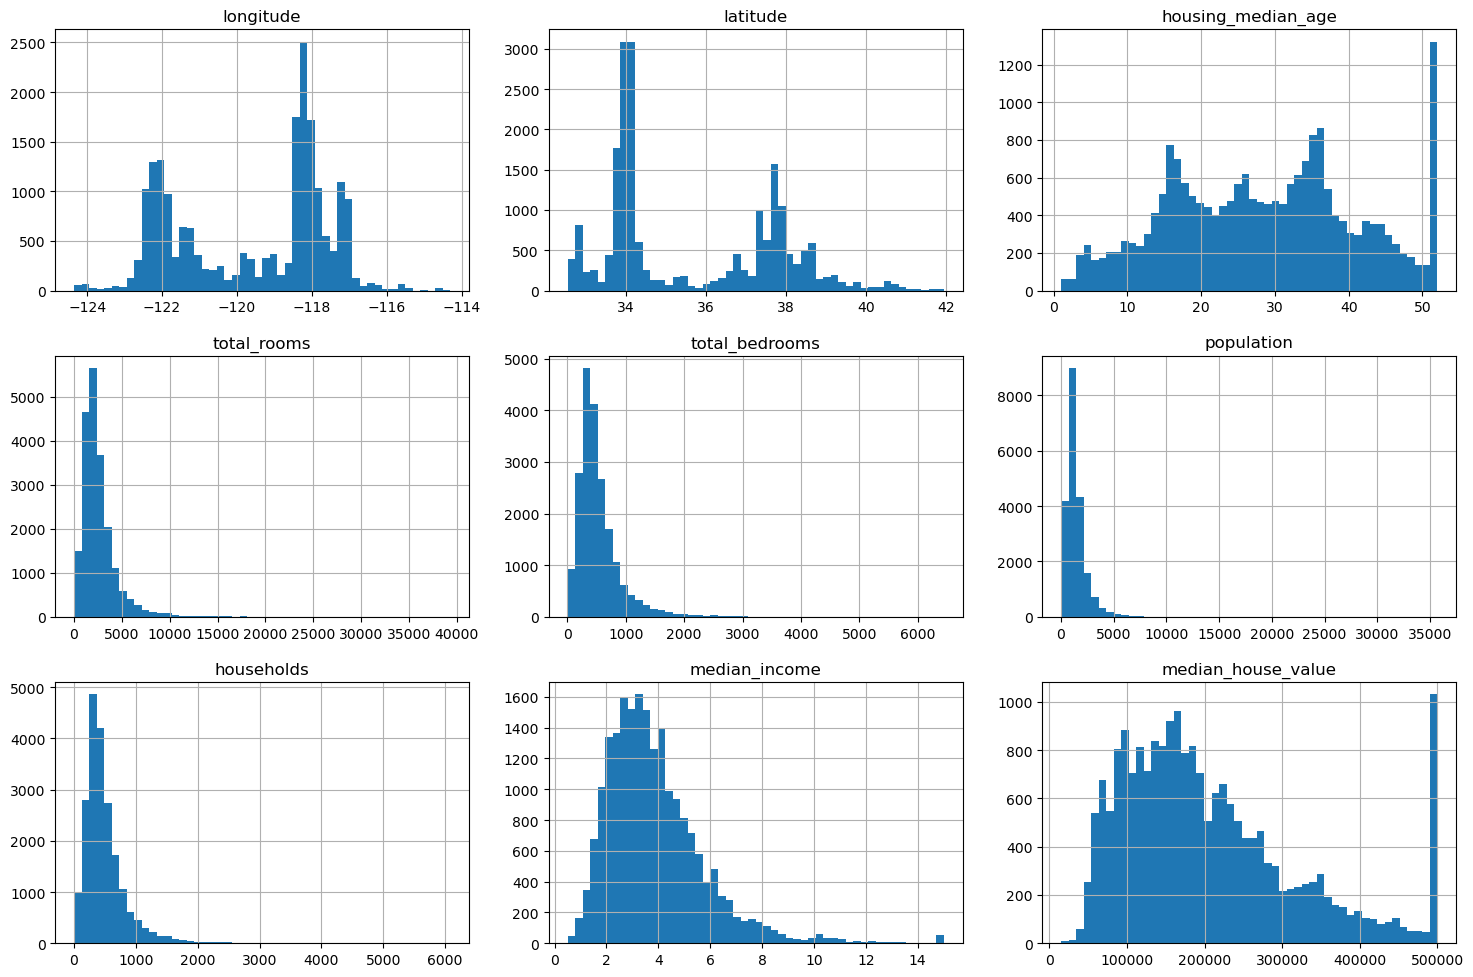

In [9]:
housing.hist(bins=50, figsize=(15, 10)) #histogram plot for all numerical attributes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
save_image("all_numerical_attributes_hist_plot")

In [10]:
# Create a new function to extract train and test data from dataset

def split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_data_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_data_set_size]
    train_indices = shuffled_indices[test_data_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

#### Well above method split data into 80% train set and 20% train set but have couple of issues like it will took inconsistent random data in each run which we want to avoid so creating another approach for split dataset

In [12]:
from zlib import crc32

In [13]:
def is_instance_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

In [14]:
def split_data_with_instance_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:is_instance_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index() #adding an index column because we need id/index in above method
train_set, test_set = split_data_with_instance_id_hash(housing_with_id, 0.2, "index")
housing_with_id.head() # added an new index column

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### we have to make sure new data aaded at the end of dataset or no row ever gets deleted
#### So we can make uniquie identifier with combination of latitude and longitude

In [16]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_data_with_instance_id_hash(housing_with_id, 0.2, "id")

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) #this sci-kit learn method will provide simliar output like split_data

In [19]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf])

Text(0, 0.5, 'No. of districts')

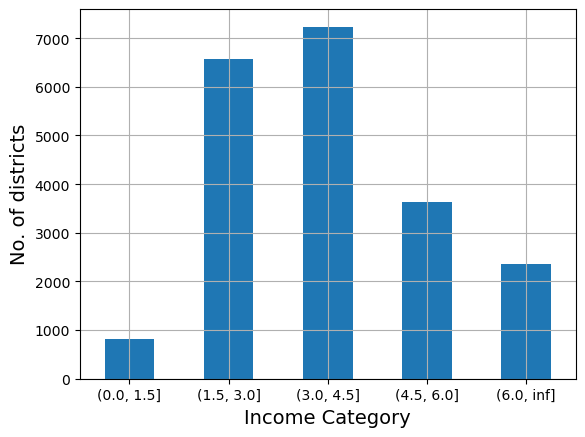

In [20]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("No. of districts")

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    train_set_n = housing.iloc[train_index]
    test_set_n = housing.iloc[test_index]
    strat_splits.append([train_set_n, test_set_n])

In [22]:
# first split
strat_train_set, strat_test_set = strat_splits[0]


In [23]:
# also we can retirieve single split with help of scikit-learn
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [24]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
(3.0, 4.5]    0.350594
(1.5, 3.0]    0.318859
(4.5, 6.0]    0.176296
(6.0, inf]    0.114462
(0.0, 1.5]    0.039789
Name: count, dtype: float64

In [25]:
# Compare income_cat proportions in overall dataset

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall (%)": income_cat_proportions(housing),
    "Stratified (%)": income_cat_proportions(strat_test_set),
    "Random (%)": income_cat_proportions(test_set)
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Stratified Error (%)"] = (compare_props["Stratified (%)"] / compare_props["Overall (%)"] - 1)
compare_props["Random Error (%)"] = (compare_props["Random (%)"] / compare_props["Overall (%)"] - 1)
(compare_props * 100).round(2)

,Overall (%),Stratified (%),Random (%),Stratified Error (%),Random Error (%)
Income Category,,,,,
"(0.0, 1.5]",3.98,4.00,4.24,0.36,6.45
"(1.5, 3.0]",31.88,31.88,30.74,-0.02,-3.59
"(3.0, 4.5]",35.06,35.05,34.52,-0.01,-1.53
"(4.5, 6.0]",17.63,17.64,18.41,0.03,4.42
"(6.0, inf]",11.44,11.43,12.09,-0.08,5.63


In [26]:
# drop income_cat column because rtest generated using random sampling is skewed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
# make copy of the data set so that if something went wrong we can rollback our changes
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

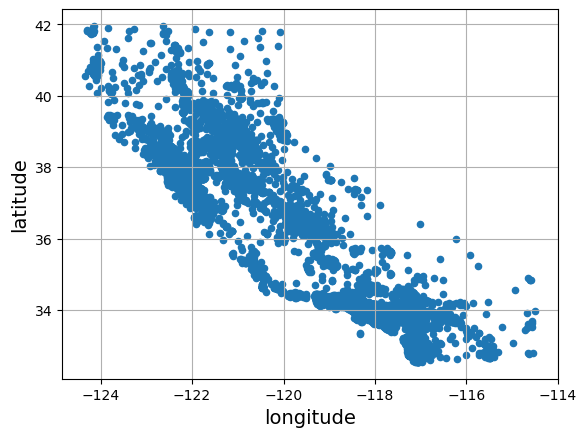

In [28]:
# Visualize geopgraphical data because our data set have latitude and longitude information
housing.plot(kind="scatter", x="longitude", y= "latitude", grid=True)

<Axes: xlabel='longitude', ylabel='latitude'>

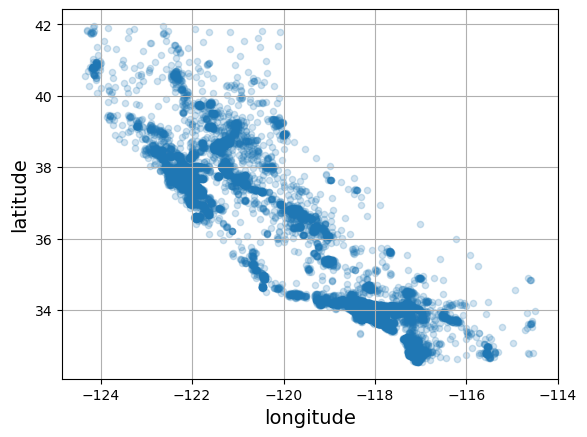

In [29]:
#Set appha value so that we can see places whith high density
housing.plot(kind="scatter", x="longitude", y= "latitude", grid=True, alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

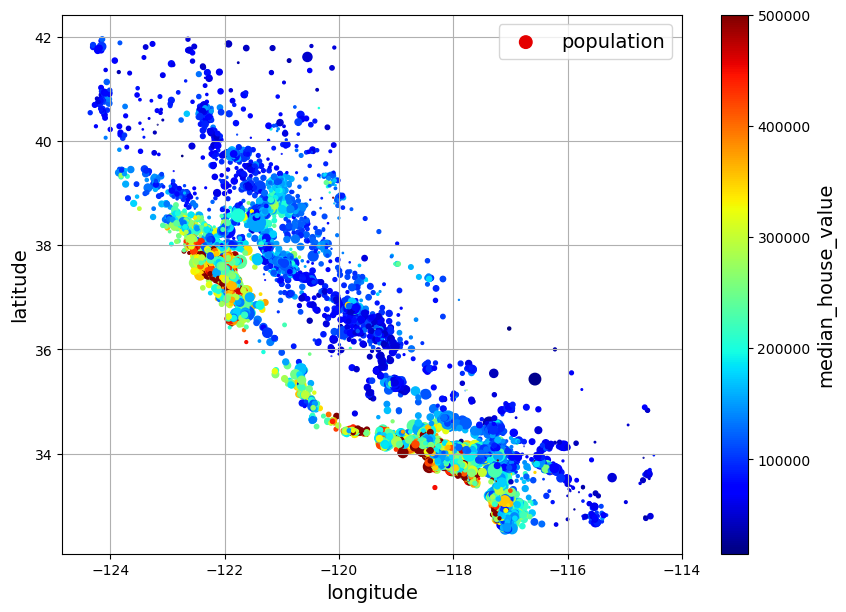

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, 
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap="jet", colorbar=True,
            legend=True, sharex=False, figsize=(10, 7))



In [31]:
# Calculate Standard Correlation Coefficient also called Pearson's r between every pair of attributes
corr_matrix = housing.corr(numeric_only=True)

In [32]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

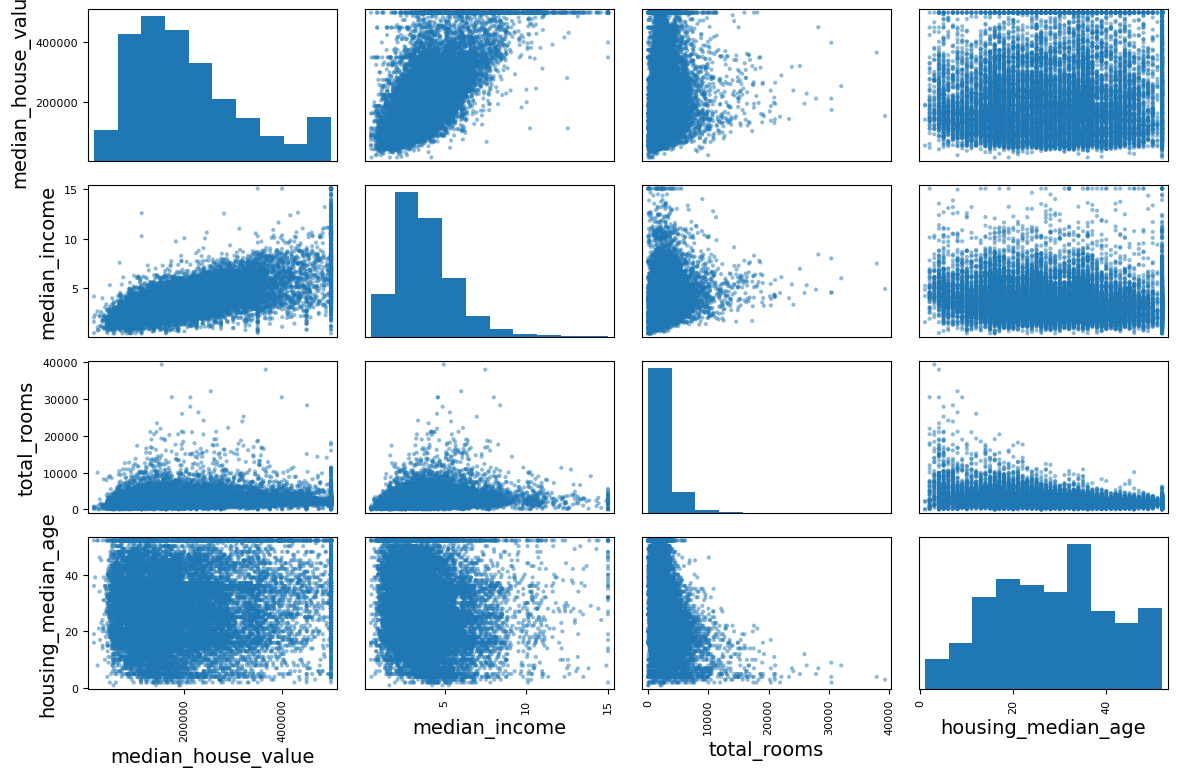

In [34]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

save_image("scatter_matrix_plot")

<Axes: xlabel='median_income', ylabel='median_house_value'>

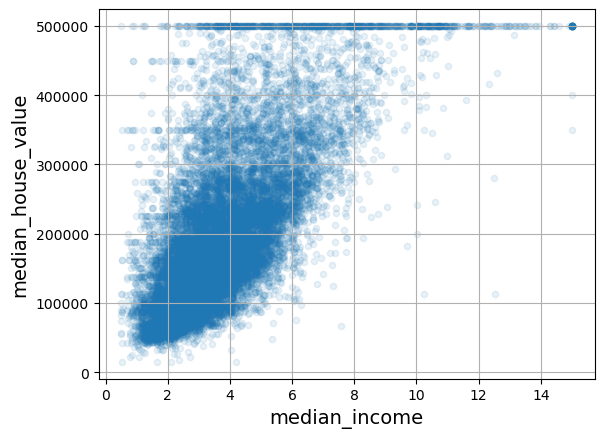

In [35]:
#Plot correlation scatterplots, the most promising attribute to predict median housing value is the median income
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

In [36]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["households"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [37]:
corr_matrix = housing.corr(numeric_only=True)

In [38]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
bedrooms_ratio       -0.045545
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

In [39]:
# Prepare dataset for machine learning algoriths
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [40]:
# we have to take care missing feature and total_bedrooms attribute have some missing values so we have 3 choices
# 1. Get rid of rows which have missing values -> housing.dropna(subset=["total_bedrooms"], inplace=True)
# 2. Rid of whole attribute -> housing.drop("total_bedrooms", axis=1)
# 3. Set missing values with zero, mean or median
# median = housing["total_bedrooms"].median()
# housing.fillna({"total_bedrooms": median}, inplace=True)

# We can use Scikit-learn SimpleImputer class 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= "median")

In [41]:
housing_num = housing.select_dtypes(include=[np.number]) # Copy of the data with numerical attributes and this will exclude text attributes ocean_proximity
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [43]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [44]:
X = imputer.transform(housing_num)

### Handing text and Categorical attributes

In [45]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [46]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # Convert text to numbers

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [47]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [48]:
housing_cat_1hot #By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [49]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
# we can also get same result with pandas get_dummies() method
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [51]:
cat_encoder.transform(df_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

In [52]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [53]:
# OneHotEncoder is smart enough to identify unknown column so it with generate an exception for unknow attributes
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (2, 5)>

In [54]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [55]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

### Feature Sacaling

In [56]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [57]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [61]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

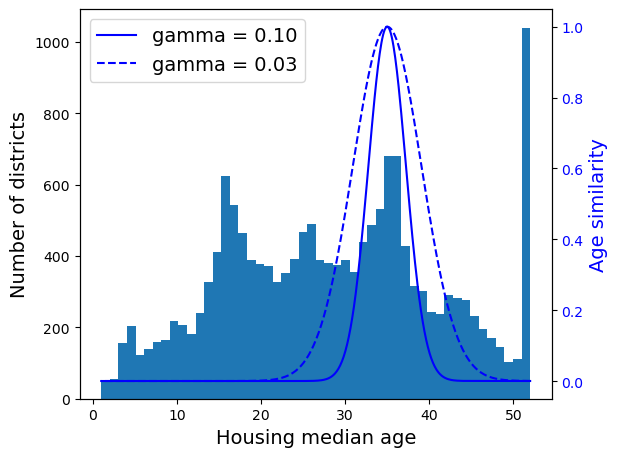

In [63]:
ages = np.linspace(housing["housing_median_age"].max(), housing["housing_median_age"].min(), 500).reshape(-1, 1)

gamma1=0.1
gamma2=0.03

rbf1 = rbf_kernel(ages, [[35]], gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_image("age_similarity_plot")

In [65]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # Assume this is the new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [66]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

### Custom Transformers

In [68]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])



In [69]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  
        X = check_array(X)  
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [71]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [72]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [73]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

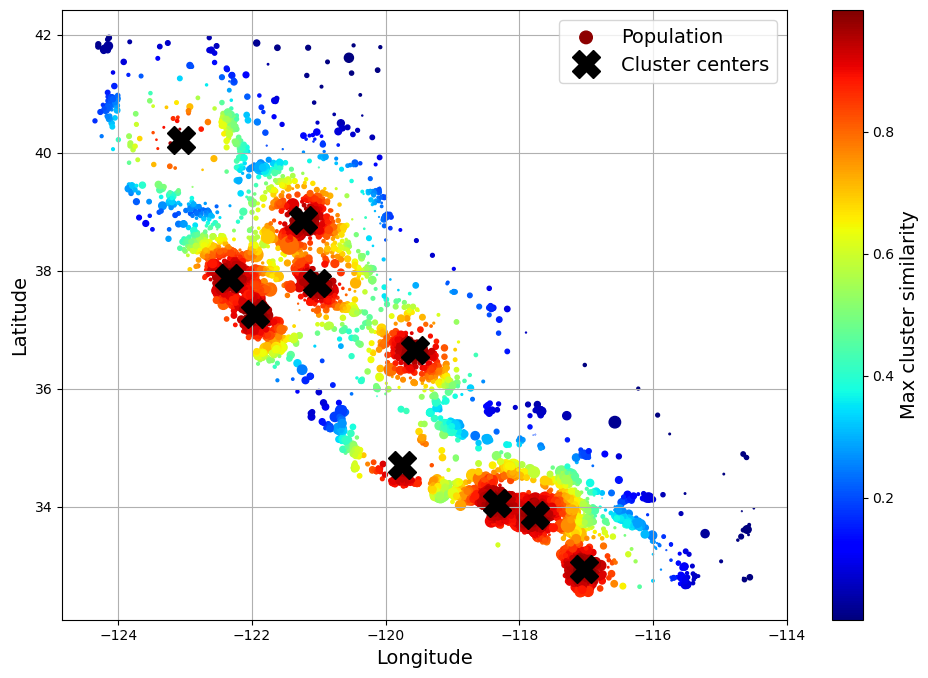

In [74]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_image("district_cluster_plot")

### Pipeline

In [75]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
    ])

In [76]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [77]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [78]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [79]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

In [81]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15eff4b90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x159de6d70>)])

In [82]:
housing_prepared = preprocessing.fit_transform(housing)

In [83]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [84]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [85]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [86]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### TRAIN YOUR MODEL

In [60]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(prep)

NameError: name 'prep' is not defined